In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
%matplotlib notebook

In [3]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features.csv', index_col=0)

In [4]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [5]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [6]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [7]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [8]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [9]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [10]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [11]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

In [12]:
metrics.confusion_matrix(test_targets, predicted_targets)

array([[  1,   0,   0,   0,   2,   0,   0,   0,   0,   0,   4,   0,   0],
       [  1,   2,   0,   0,   1,   0,   0,   0,   0,   0,   2,   0,   0],
       [  0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   1,  10,   0,   1,   0,   0,   0,   1,   1,   0],
       [  0,   0,   0,   7, 121,   1,   2,   1,   0,   1,   2,   2,   0],
       [  0,   0,   0,   0,   1, 155,   5,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,  14, 107,  12,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   7,   0,  12,  57,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  1,   1,   0,   0,   1,   0,   0,   0,   0,   1,   1,   0,   0],
       [  2,   2,   0,   0,  11,   0,   0,   0,   0,   0,  28,   0,   0],
       [  0,   0,   0,   0,   1,   8,   0,   0,   0,   0,   1,  74,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3]])

In [13]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [14]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [15]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


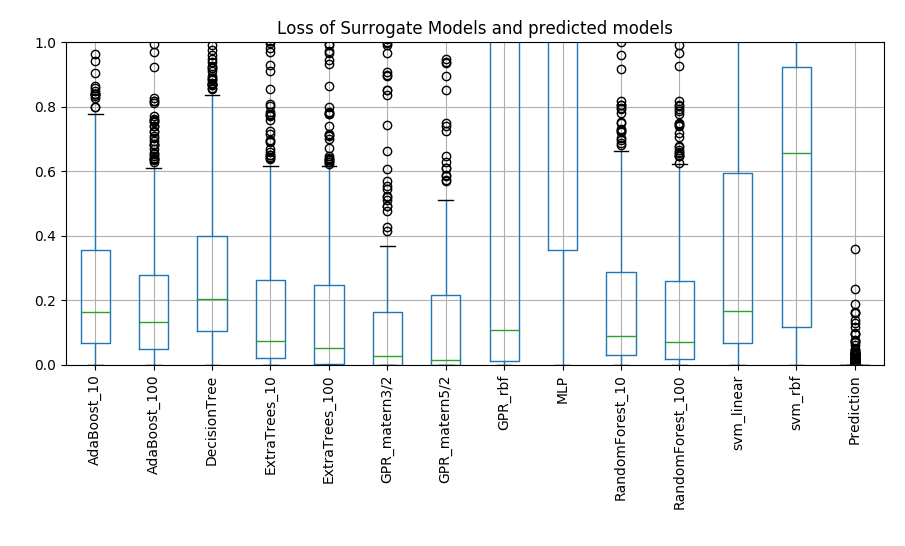

Prediction    0.029509
Name: 0.95, dtype: float64

In [16]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [17]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction
count,678.000000,678.000000,678.000000,678.000000,678.000000,6.780000e+02,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,0.265301,0.222110,0.299091,0.191661,0.175755,5.849190e-01,1.184146,25.687036,4.222879,0.206559,0.192409,0.372948,0.599708,0.005283
std,0.289050,0.269227,0.294209,0.265359,0.267044,1.568410e+00,5.010945,96.782781,6.233901,0.272079,0.273278,0.471709,0.511826,0.024767
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.068071,0.048161,0.103158,0.021682,0.001529,2.100675e-11,0.000160,0.011599,0.354531,0.031114,0.017720,0.066092,0.115766,-0.000000
50%,0.162955,0.133649,0.204913,0.072382,0.051916,2.802444e-02,0.015892,0.108997,1.229479,0.089800,0.070142,0.166213,0.656319,-0.000000
75%,0.354615,0.278521,0.400494,0.263659,0.248312,1.635727e-01,0.215196,2.813910,4.995000,0.287158,0.260282,0.596252,0.923380,-0.000000
max,1.543183,1.528313,1.562189,1.482484,1.496995,1.079766e+01,58.379966,640.163801,42.903156,1.519932,1.517765,3.699874,2.631302,0.359738


## Feature Importances

In [18]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


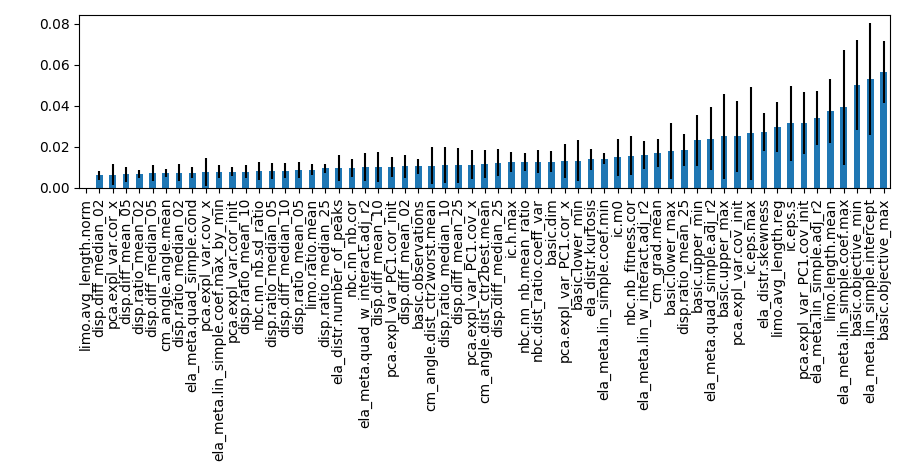

In [19]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.tight_layout()